In [ ]:
!pip install ranx

In [ ]:
!wget -O trec-pm.tar.xz https://th-koeln.sciebo.de/s/JTTV4fxFmuCGMeY/download
!tar -xf trec-pm.tar.xz

In [ ]:
!wget -O bibliometric.tar.xz https://th-koeln.sciebo.de/s/BRolGxMzrCipoTT/download
!tar -xf bibliometric.tar.xz

In [1]:
DIR_IN = 'trec-pm/trec-pm-2017-abstracts' 
DIR_RUN = 'runs/trec-pm-2017-abstracts'    
PATH_QRELS = "trec-pm/trec-pm-2017-abstracts/qrels-final-abstracts.txt"
DIR_CSV = 'experimental_results/trec-pm-2017-abstracts/'
YEAR = 2017

# DIR_IN = 'trec-pm/trec-pm-2018-abstracts' 
# DIR_RUN = 'runs/trec-pm-2018-abstracts'    
# PATH_QRELS = "trec-pm/trec-pm-2018-abstracts/qrels-treceval-abstracts-2018-v2.txt"
# DIR_CSV = 'experimental_results/trec-pm-2018-abstracts/'
# YEAR = 2018

# DIR_IN = 'trec-pm/trec-pm-2019-abstracts' 
# DIR_RUN = 'runs/trec-pm-2019-abstracts'    
# PATH_QRELS = "trec-pm/trec-pm-2019-abstracts/qrels-treceval-abstracts.2019.txt"
# DIR_CSV = 'experimental_results/trec-pm-2019-abstracts/'
# YEAR = 2019

In [4]:
import os
import gzip

def extract_runs(dir_in, dir_out):

    os.makedirs(dir_out, exist_ok=True)

    for root, dirs, files in os.walk(dir_in):
        for file in files:
            if file.endswith(".gz"):
                run_name = file.split('.')[1]
                with gzip.open(os.path.join(root, file), 'rb') as f_in:
                    file_content = f_in.read()
                    file_out = dir_out + '/' + run_name
                    with open(file_out, 'wb') as f_out:
                        f_out.write(file_content) 
                        if YEAR == 2019:
                            !cat $file_out | cut -d" " -f1 > tmp; mv tmp $file_out
                            
extract_runs(DIR_IN, DIR_RUN)

In [138]:
from ranx import Qrels, Run, evaluate, compare, fuse
import matplotlib.pyplot as plt
import pandas as pd

from random import randint

def get_run(category, year=2017):
    
    run_names = {'TC': 'Citations (C)',
                 'ATTENTION_SCORE': 'Altmetrics (A)',
                 'RL': 'Research level (R)',
                 'IF': 'Impact factor (I)',
                 'PY': 'Publication year (P)',
                 'random': 'Random'}
    
    
    df = pd.read_csv('STI_Ergebnisse_final.txt', sep='\t')
    _run = Run(name=run_names[category])
    
    if category == 'random':
        _df = df[df['TOPIC'].str.contains(str(year), regex=False)]
        for row in _df.iterrows():
            topic = row[1]['TOPIC'].split('-')[1]
            pubmed_id = row[1]['PUBMED_ID']
            _run.add_score(str(topic), str(pubmed_id), randint(1,10000))
            
        return _run
    
    _df = df[df[category].notna()]
    _df = _df[_df['TOPIC'].str.contains(str(year), regex=False)]
    _df = _df[['TOPIC','PUBMED_ID', category]]
    
    if category in ['IF', 'RL']:
        _df[category] = _df[category].str.replace(',','.').astype(float)

    for row in _df.iterrows():
        topic = row[1]['TOPIC'].split('-')[1]
        pubmed_id = row[1]['PUBMED_ID']
        cnt = row[1][category]

        if cnt > 0:
            _run.add_score(str(topic), str(pubmed_id), float(cnt))
    
    return _run

In [139]:
qrels = Qrels.from_file(PATH_QRELS, kind="trec")

run_cite = get_run('TC', year=YEAR) # get run based on citations
run_alt = get_run('ATTENTION_SCORE', year=YEAR) # get run based on attention score
run_py = get_run('PY', year=YEAR) 
run_rl = get_run('RL', year=YEAR) 
run_if = get_run('IF', year=YEAR) 
run_random = get_run('random', year=YEAR) 

/tmp/ipykernel_67600/3418591337.py:3: DtypeWarning: Columns (2,5,7,8,9,10,12,13,14,15,16,18) have mixed types.Specify dtype option on import or set low_memory=False.
  run_cite = get_run('TC', year=YEAR) # get run based on citations
/tmp/ipykernel_67600/3418591337.py:4: DtypeWarning: Columns (2,5,7,8,9,10,12,13,14,15,16,18) have mixed types.Specify dtype option on import or set low_memory=False.
  run_alt = get_run('ATTENTION_SCORE', year=YEAR) # get run based on attention score
/tmp/ipykernel_67600/3418591337.py:5: DtypeWarning: Columns (2,5,7,8,9,10,12,13,14,15,16,18) have mixed types.Specify dtype option on import or set low_memory=False.
  run_rl = get_run('RL', year=YEAR)
/tmp/ipykernel_67600/3418591337.py:6: DtypeWarning: Columns (2,5,7,8,9,10,12,13,14,15,16,18) have mixed types.Specify dtype option on import or set low_memory=False.
  run_if = get_run('IF', year=YEAR)
/tmp/ipykernel_67600/3418591337.py:7: DtypeWarning: Columns (2,5,7,8,9,10,12,13,14,15,16,18) have mixed types.Sp

In [145]:
report = compare(
    qrels=qrels,
    runs=[run_cite, run_alt, run_rl, run_py, run_if, run_random],
    metrics=["ndcg", "map", "precision@10", "bpref", "mrr"],
    max_p=0.05 / 6 # bonferroni correction    
)

print(report)
# print(report.to_latex())

#    Model                 NDCG      MAP       P@10    BPref      MRR
---  --------------------  --------  --------  ------  -------  -----
a    Citations (C)         0.499ᵇᶜᵈ  0.181ᵇᵈᶠ  0.270ᶜ  0.158ᶠ   0.392
b    Altmetrics (A)        0.316     0.102     0.240ᶜ  0.143    0.382
c    Research level (R)    0.467ᵇᵈ   0.155ᵇ    0.120   0.131    0.246
d    Impact factor (I)     0.416ᵇ    0.140ᵇ    0.250ᶜ  0.144ᶠ   0.382
e    Publication year (P)  0.507ᵇᶜᵈ  0.173ᵇᵈ   0.203   0.154ᶠ   0.374
f    Random                0.519ᵇᶜᵈ  0.160ᵇᵈ   0.173   0.117    0.412


In [146]:
report = compare(
    qrels=qrels,
    runs=[run_cite, run_alt, run_rl, run_py, run_if, run_random],
    metrics=["rbp.95", "rbp.9", "rbp.85", "rbp.8", "rbp.75"],
    max_p=0.05 / 6 # bonferroni correction   
)

print(report)
# print(report.to_latex())

#    Model                 RBP.95    RBP.9    RBP.85      RBP.8    RBP.75
---  --------------------  --------  -------  --------  -------  --------
a    Citations (C)         0.251ᶜᶠ   0.260ᶜ   0.261       0.26      0.259
b    Altmetrics (A)        0.237ᶜᶠ   0.239ᶜ   0.237ᶜ      0.233     0.229
c    Research level (R)    0.154     0.141    0.134       0.129     0.126
d    Impact factor (I)     0.227     0.235    0.239       0.24      0.239
e    Publication year (P)  0.214ᶜ    0.213    0.211       0.211     0.213
f    Random                0.176     0.182    0.188       0.195     0.202


In [147]:
report = compare(
    qrels=qrels,
    runs=[run_cite, run_alt, run_rl, run_py, run_if, run_random],
    metrics=["ndcg@1", "ndcg@5", "ndcg@10", "ndcg@100", "ndcg@1000"],
    max_p=0.05 / 6 # bonferroni correction  
)

print(report)
# print(report.to_latex())

#    Model                   NDCG@1  NDCG@5    NDCG@10    NDCG@100    NDCG@1000
---  --------------------  --------  --------  ---------  ----------  -----------
a    Citations (C)            0.133  0.176     0.197      0.222ᶜᶠ     0.499ᵇᶜᵈ
b    Altmetrics (A)           0.183  0.198ᶜ    0.193ᶜ     0.232ᶜᶠ     0.316
c    Research level (R)       0.05   0.085     0.084      0.161       0.467ᵇᵈ
d    Impact factor (I)        0.183  0.181     0.186ᶜ     0.208ᶠ      0.416ᵇ
e    Publication year (P)     0.233  0.181     0.174      0.222ᶜᶠ     0.507ᵇᶜᵈ
f    Random                   0.167  0.139     0.133      0.162       0.519ᵇᶜᵈ


In [149]:
fuse_method = 'rrf'

fused_runs = []

run_dict = {'C': run_cite,
            'A': run_alt,
            'P': run_py,
            'R': run_rl,
            'I': run_if}

# https://stackoverflow.com/questions/464864/how-to-get-all-possible-combinations-of-a-list-s-elements
import itertools

# run_codes = ['a', 'b', 'c', 'd', 'e']
run_codes = list(run_dict.keys())

for L in range(len(run_codes) + 1):
    for subset in itertools.combinations(run_codes, L):
        if len(subset) > 1:
            
            run_name = ''.join(list(subset))
            comb = [run_dict.get(code) for code in subset]
            run_fuse = fuse(runs=comb, method=fuse_method)
            run_fuse.name = run_name
            fused_runs.append(run_fuse)
                 
# runs = [run_cite, run_alt, run_rl, run_if, run_py, run_random] + fused_runs
  
report = compare(
    qrels=qrels,
    runs=fused_runs,
    metrics=["ndcg", "map", "precision@10", "bpref", "mrr"],
    max_p=0.01 / 26
)

print(report)
# print(report.to_latex())

#    Model    NDCG              MAP             P@10  BPref      MRR
---  -------  ----------------  ------------  ------  -------  -----
a    CA       0.526ᶜᶠʰⁿ         0.192ᶠʰ        0.27   0.167    0.507
b    CR       0.497ʰ            0.172          0.207  0.146    0.416
c    CI       0.503ʰ            0.178          0.277  0.154    0.428
d    CP       0.522ᶠʰ           0.192ʰᵗ        0.273  0.169ʰ   0.518
e    AR       0.506ʰ            0.174ʰ         0.227  0.151    0.402
f    AI       0.487             0.171          0.297  0.159    0.498
g    AP       0.530ᶠʰᶦᵗ         0.188          0.253  0.170    0.487
h    RI       0.475             0.159          0.2    0.135    0.406
i    RP       0.498ʰ            0.168          0.22   0.142    0.32
j    IP       0.516ᶠʰ           0.179          0.277  0.156    0.506
k    CAR      0.519ᵇᶠʰⁿˣ        0.185ʰⁿ        0.257  0.158ʰ   0.456
l    CAI      0.527ᶜᶠʰⁿ         0.190ᶜʰ        0.273  0.163    0.54
m    CAP      0.537ᵇᶜᵉᶠʰᶦⁿᵖ۹ᵗˣ  0.19

In [ ]:
fuse_method = "rrf"

df_data = []

for root, dirs, files in os.walk(DIR_RUN):
    for file in files:
        run = Run.from_file(os.path.join(root, file), kind="trec")
        
        run_rrf = fuse(runs=[run, run_cite, run_alt], method=fuse_method)

        report = compare(
            qrels=qrels,
            runs=[run, run_rrf],
            metrics=["ndcg", "map", "precision@10", "bpref", "mrr"],
            max_p=0.05  
        )

        report_dict = report.to_dict()
        metrics = report_dict.get('metrics')
        base_name = report_dict.get('model_names')[0]
        base_scores = report_dict.get(base_name).get('scores')
        fuse_scores = report_dict.get(fuse_method).get('scores')
        base_pval = report_dict.get(base_name).get('comparisons').get(fuse_method)

        _eval = {'run': base_name}

        for metric in metrics:
            _eval[metric + ' (base)'] = base_scores.get(metric)
            _eval[metric + ' (fuse)'] = fuse_scores.get(metric)
            _eval[metric + ' (diff)'] = fuse_scores.get(metric) - base_scores.get(metric)
            _eval[metric + ' (pval)'] = base_pval.get(metric)
            
        df_data.append(_eval)
        
df = pd.DataFrame(df_data)

os.makedirs(DIR_CSV, exist_ok=True)
file_out = DIR_CSV + fuse_method + '.csv'
df.to_csv(file_out)

# TREC PM 2017 - Abstracts

## AP

<AxesSubplot:xlabel='run'>

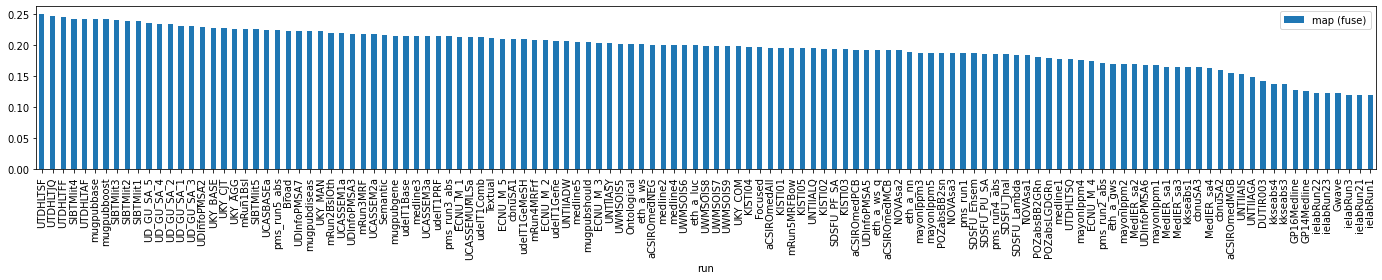

In [ ]:
df = pd.read_csv('experimental_results/trec-pm-2017-abstracts/rrf.csv')
df.sort_values(by=['map (fuse)'], ascending=False).plot.bar(x='run', y='map (fuse)', figsize=(24,3))

## nDCG

<AxesSubplot:xlabel='run'>

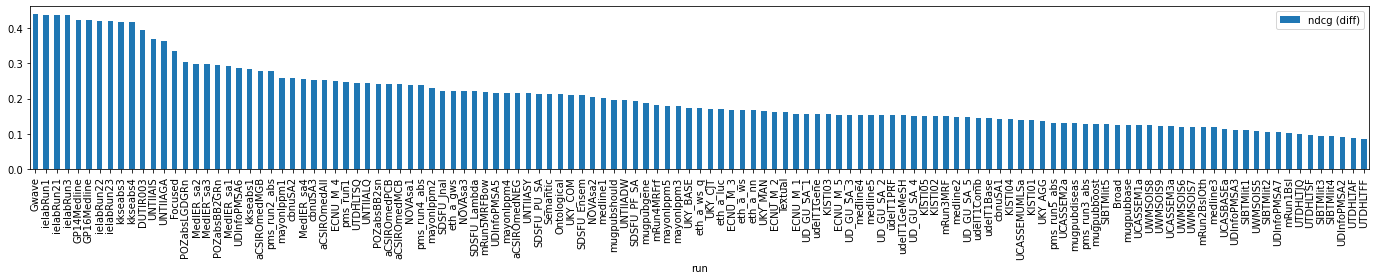

In [ ]:
df.sort_values(by=['ndcg (diff)'], ascending=False).plot.bar(x='run', y='ndcg (diff)', figsize=(24,3))

## P@10

<AxesSubplot:xlabel='run'>

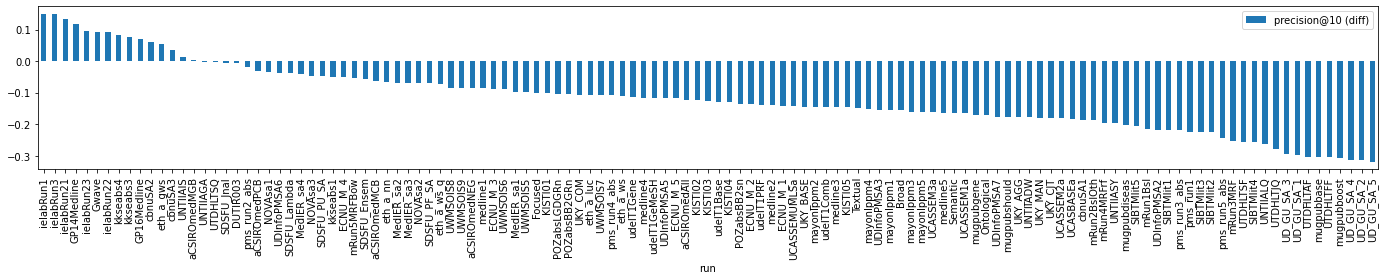

In [ ]:
df.sort_values(by=['precision@10 (diff)'], ascending=False).plot.bar(x='run', y='precision@10 (diff)', figsize=(24,3))

## Bpref

<AxesSubplot:xlabel='run'>

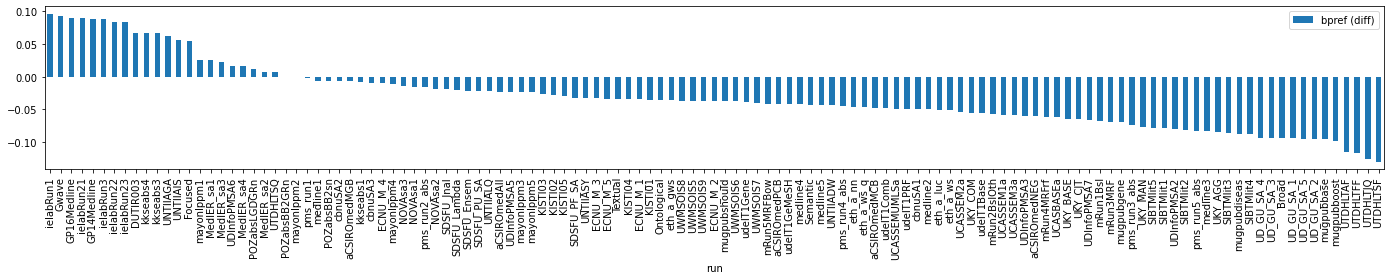

In [ ]:
df.sort_values(by=['bpref (diff)'], ascending=False).plot.bar(x='run', y='bpref (diff)', figsize=(24,3))

## MRR

<AxesSubplot:xlabel='run'>

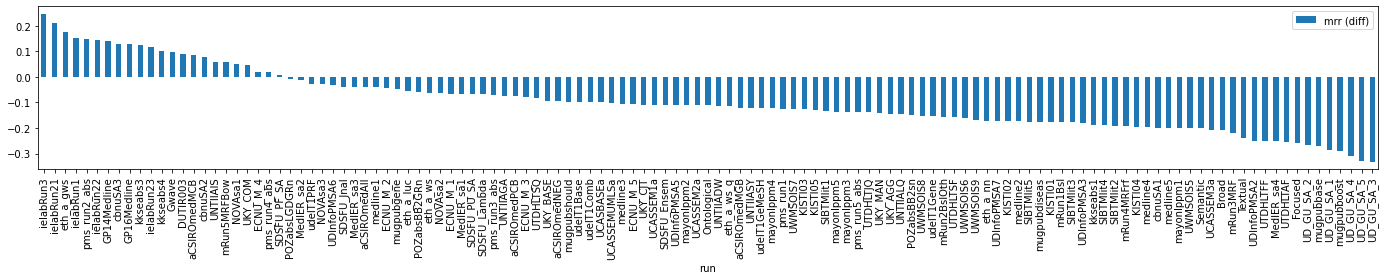

In [ ]:
df.sort_values(by=['mrr (diff)'], ascending=False).plot.bar(x='run', y='mrr (diff)', figsize=(24,3))

# TREC PM 2018 - Abstracts

## AP

<AxesSubplot:xlabel='run'>

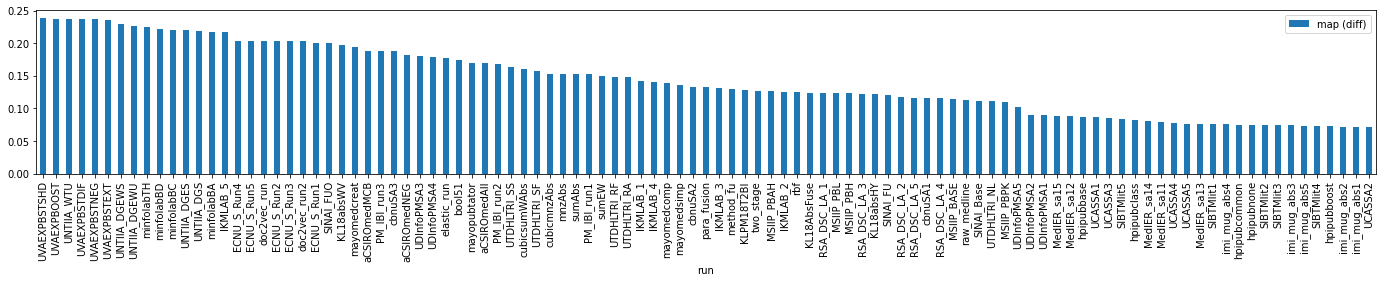

In [ ]:
df = pd.read_csv('experimental_results/trec-pm-2018-abstracts/rrf.csv')
df.sort_values(by=['map (diff)'], ascending=False).plot.bar(x='run', y='map (diff)', figsize=(24,3))

## nDCG

<AxesSubplot:xlabel='run'>

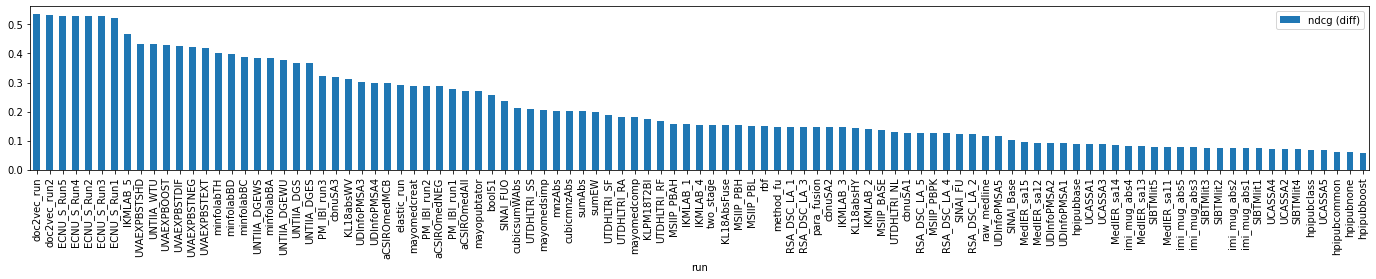

In [ ]:
df.sort_values(by=['ndcg (diff)'], ascending=False).plot.bar(x='run', y='ndcg (diff)', figsize=(24,3))

## P@10

<AxesSubplot:xlabel='run'>

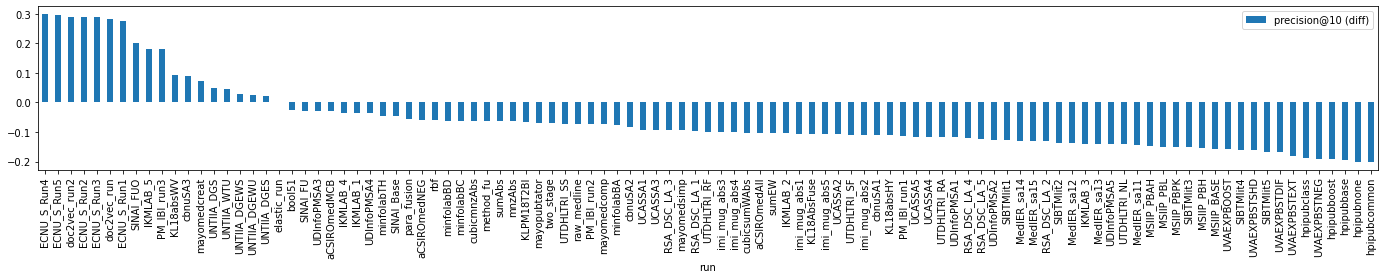

In [ ]:
df.sort_values(by=['precision@10 (diff)'], ascending=False).plot.bar(x='run', y='precision@10 (diff)', figsize=(24,3))

## Bpref

<AxesSubplot:xlabel='run'>

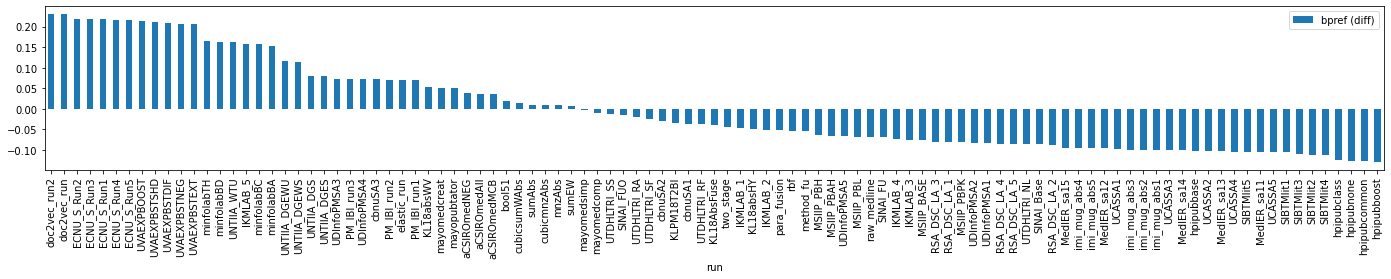

In [ ]:
df.sort_values(by=['bpref (diff)'], ascending=False).plot.bar(x='run', y='bpref (diff)', figsize=(24,3))

## MRR

<AxesSubplot:xlabel='run'>

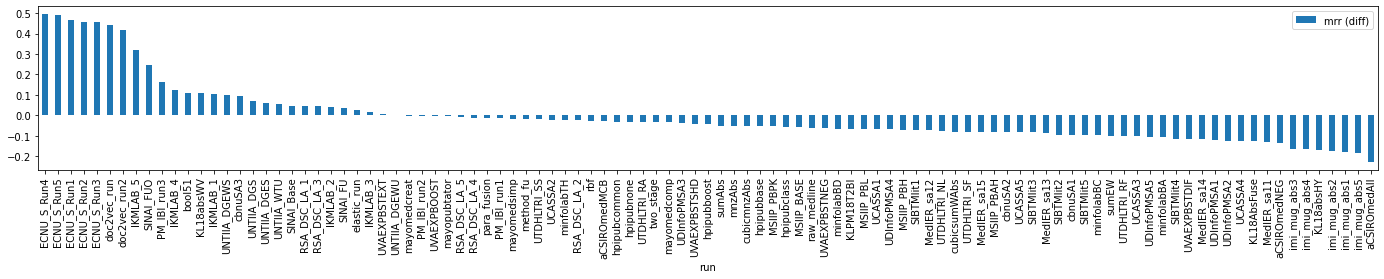

In [ ]:
df.sort_values(by=['mrr (diff)'], ascending=False).plot.bar(x='run', y='mrr (diff)', figsize=(24,3))

# TREC PM 2019 - Abstracts

## AP

<AxesSubplot:xlabel='run'>

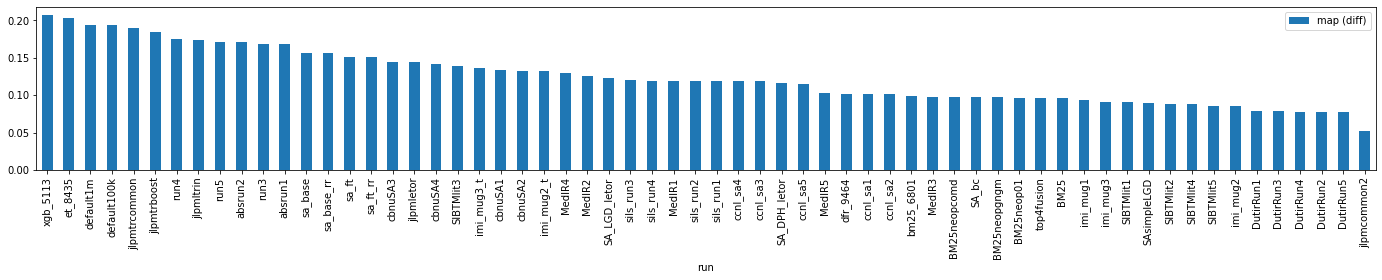

In [ ]:
df = pd.read_csv('experimental_results/trec-pm-2019-abstracts/rrf.csv')
df.sort_values(by=['map (diff)'], ascending=False).plot.bar(x='run', y='map (diff)', figsize=(24,3))

## nDCG

<AxesSubplot:xlabel='run'>

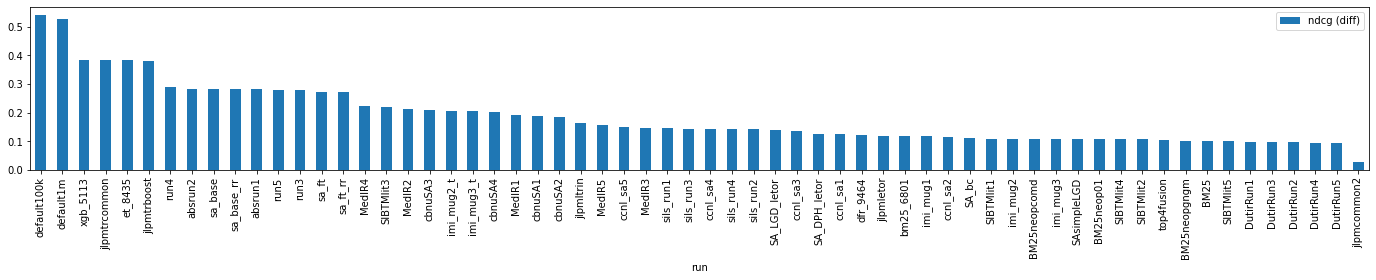

In [ ]:
df.sort_values(by=['ndcg (diff)'], ascending=False).plot.bar(x='run', y='ndcg (diff)', figsize=(24,3))

## P@10

<AxesSubplot:xlabel='run'>

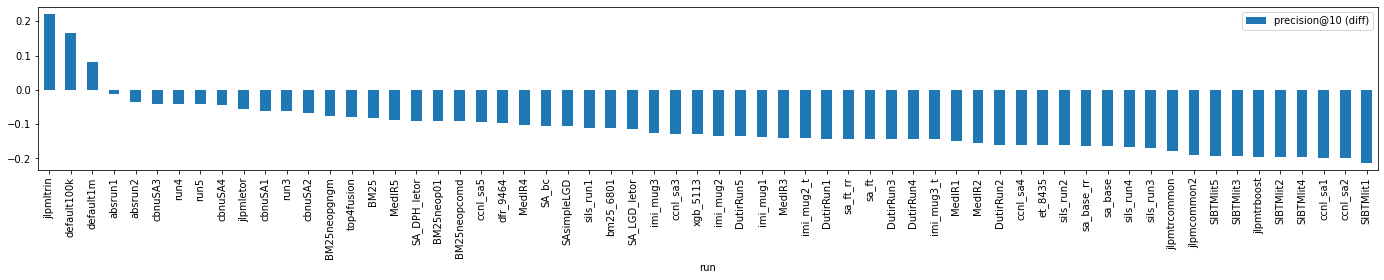

In [ ]:
df.sort_values(by=['precision@10 (diff)'], ascending=False).plot.bar(x='run', y='precision@10 (diff)', figsize=(24,3))

## Bpref

<AxesSubplot:xlabel='run'>

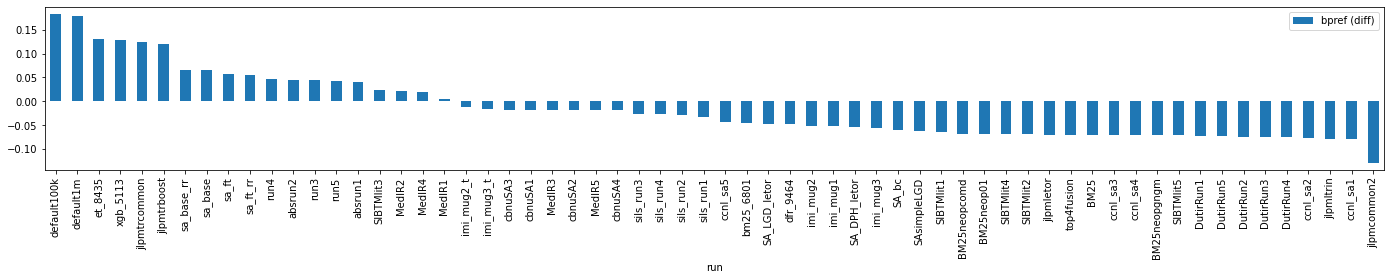

In [ ]:
df.sort_values(by=['bpref (diff)'], ascending=False).plot.bar(x='run', y='bpref (diff)', figsize=(24,3))

## MRR

<AxesSubplot:xlabel='run'>

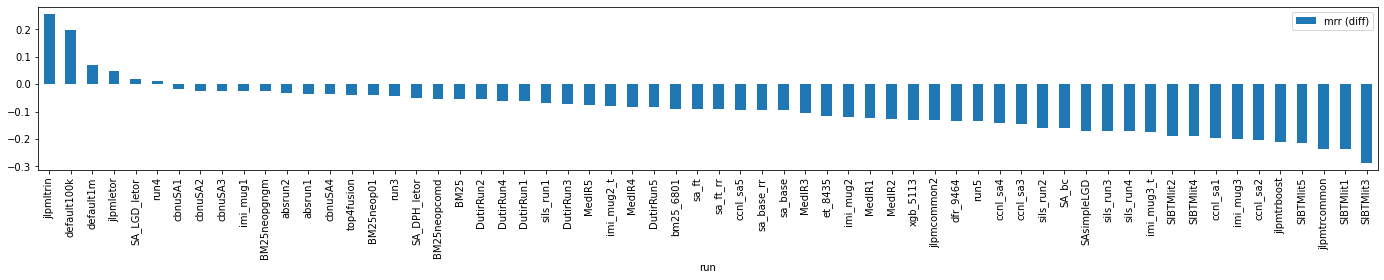

In [ ]:
df.sort_values(by=['mrr (diff)'], ascending=False).plot.bar(x='run', y='mrr (diff)', figsize=(24,3))

# Optimized Fusion Methods

see also: https://amenra.github.io/ranx/fusion/

In [ ]:
from ranx import fuse, optimize_fusion, Qrels, Run
import os, random
import matplotlib.pyplot as plt
import pandas as pd

# fuse_method = "wsum"
# fuse_dict_key = "weighted_sum"

# fuse_method = "gmnz"
# fuse_dict_key = "comb_gmnz"

# fuse_method = "rbc"
# fuse_dict_key = fuse_method

# fuse_method = "probfuse"
# fuse_dict_key = fuse_method

# fuse_method = "slidefuse"
# fuse_dict_key = fuse_method

# fuse_method = "bayesfuse"
# fuse_dict_key = fuse_method

# fuse_method = "logn_isr"
# fuse_dict_key = fuse_method

# fuse_method = "posfuse"
# fuse_dict_key = fuse_method

# fuse_method = "mapfuse"
# fuse_dict_key = fuse_method

fuse_method = "segfuse"
fuse_dict_key = fuse_method

if YEAR == 2017:
    samples = 5
    dir_train = 'runs/trec-pm-2018-abstracts/'
    train_runs = [Run.from_file(dir_train + random.choice(os.listdir(dir_train)), kind='trec') for i in range(0,samples)]
    train_qrels = Qrels.from_file('trec-pm/trec-pm-2018-abstracts/qrels-treceval-abstracts-2018-v2.txt', kind="trec")
    
if YEAR == 2018:
    samples = 5
    dir_train = 'runs/trec-pm-2019-abstracts/'
    train_runs = [Run.from_file(dir_train + random.choice(os.listdir(dir_train)), kind='trec') for i in range(0,samples)]
    train_qrels = Qrels.from_file('trec-pm/trec-pm-2019-abstracts/qrels-treceval-abstracts.2019.txt', kind="trec")

if YEAR == 2019:
    samples = 5
    dir_train = 'runs/trec-pm-2017-abstracts/'
    train_runs = [Run.from_file(dir_train + random.choice(os.listdir(dir_train)), kind='trec') for i in range(0,samples)]
    train_qrels = Qrels.from_file('trec-pm/trec-pm-2017-abstracts/qrels-final-abstracts.txt', kind="trec")

best_params = optimize_fusion(
    qrels=train_qrels,
    runs=train_runs,
    norm="min-max",
    method=fuse_method,
    metric="ndcg@100"
)

run_cite = get_run('TC', year=YEAR) # get run based on citations
run_alt = get_run('ATTENTION_SCORE', year=YEAR) # get run based on attention score
qrels = Qrels.from_file(PATH_QRELS, kind="trec")

df_data = []

for root, dirs, files in os.walk(DIR_RUN):
    for file in files:
        run = Run.from_file(os.path.join(root, file), kind="trec")
        
        run_fuse = fuse(
            runs=[run, run_cite, run_alt],  
            norm="min-max",       
            method=fuse_method,        
            params=best_params,
        )

        report = compare(
            qrels=qrels,
            runs=[run, run_fuse],
            metrics=["ndcg", "map", "precision@10", "bpref", "mrr"],
            max_p=0.05  
        )

        report_dict = report.to_dict()
        metrics = report_dict.get('metrics')
        base_name = report_dict.get('model_names')[0]
        base_scores = report_dict.get(base_name).get('scores')
        fuse_scores = report_dict.get(fuse_dict_key).get('scores')
        base_pval = report_dict.get(base_name).get('comparisons').get(fuse_dict_key)

        _eval = {'run': base_name}

        for metric in metrics:
            _eval[metric + ' (base)'] = base_scores.get(metric)
            _eval[metric + ' (fuse)'] = fuse_scores.get(metric)
            _eval[metric + ' (diff)'] = fuse_scores.get(metric) - base_scores.get(metric)
            _eval[metric + ' (pval)'] = base_pval.get(metric)
            
        df_data.append(_eval)
        
df = pd.DataFrame(df_data)

os.makedirs(DIR_CSV, exist_ok=True)
file_out = DIR_CSV + fuse_method + '.csv'
df.to_csv(file_out)

## AP

<AxesSubplot:xlabel='run'>

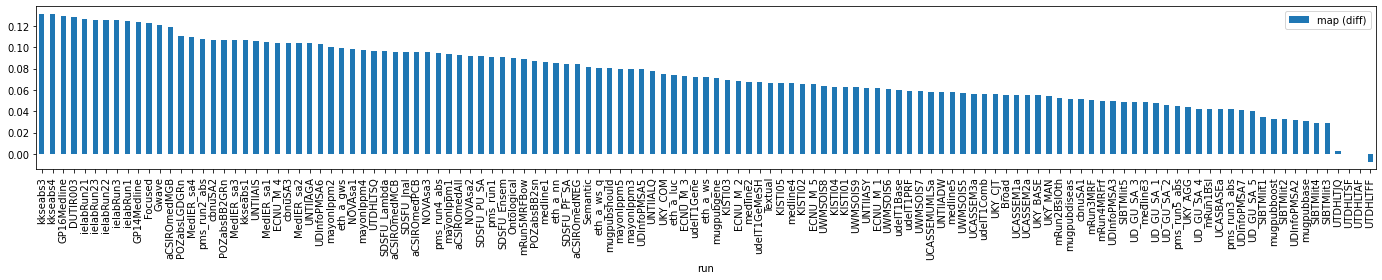

In [ ]:
df = pd.read_csv('experimental_results/trec-pm-' + str(YEAR) + '-abstracts/' + fuse_method + '.csv')
df.sort_values(by=['map (diff)'], ascending=False).plot.bar(x='run', y='map (diff)', figsize=(24,3))

## nDCG

<AxesSubplot:xlabel='run'>

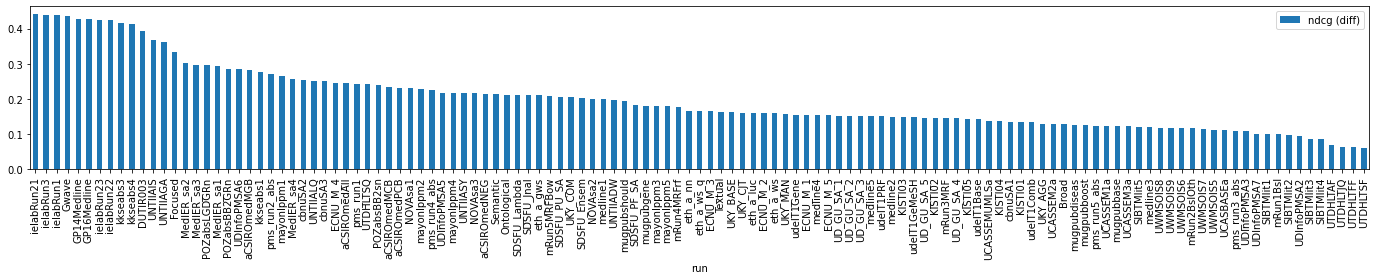

In [ ]:
df.sort_values(by=['ndcg (diff)'], ascending=False).plot.bar(x='run', y='ndcg (diff)', figsize=(24,3))

## P@10

<AxesSubplot:xlabel='run'>

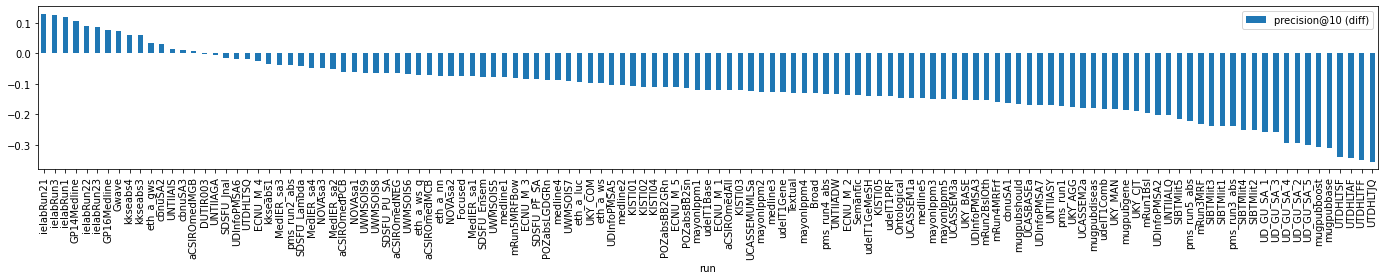

In [ ]:
df.sort_values(by=['precision@10 (diff)'], ascending=False).plot.bar(x='run', y='precision@10 (diff)', figsize=(24,3))

## Bpref

<AxesSubplot:xlabel='run'>

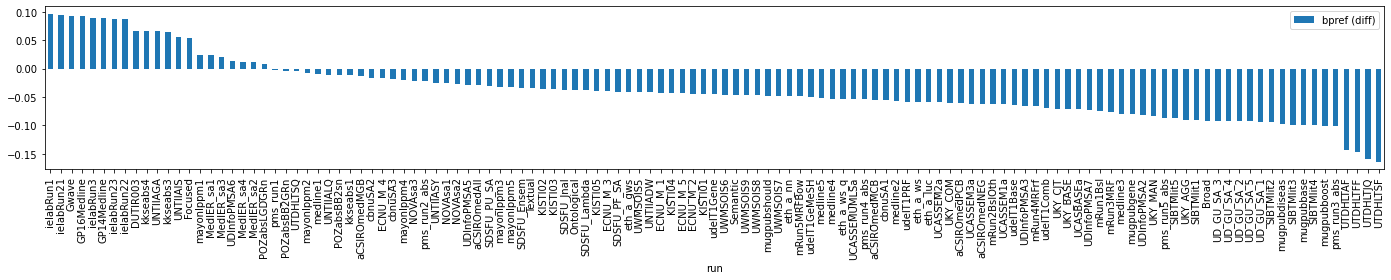

In [ ]:
df.sort_values(by=['bpref (diff)'], ascending=False).plot.bar(x='run', y='bpref (diff)', figsize=(24,3))

## MRR

<AxesSubplot:xlabel='run'>

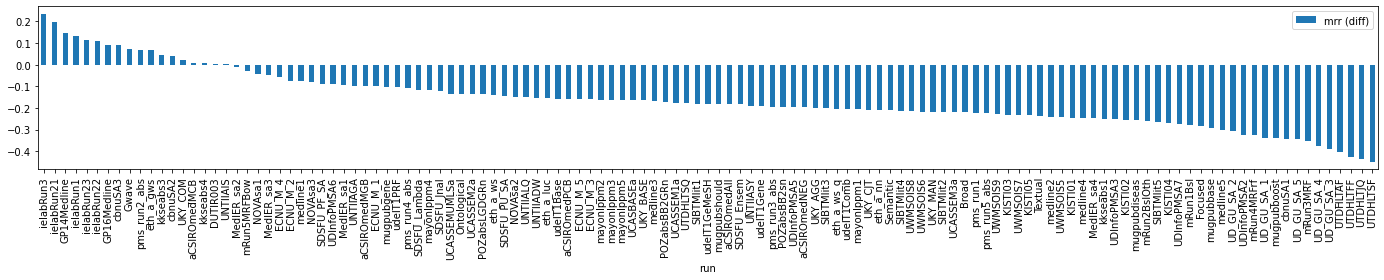

In [ ]:
df.sort_values(by=['mrr (diff)'], ascending=False).plot.bar(x='run', y='mrr (diff)', figsize=(24,3))